<h1> SHapley Additive exPlanations (SHAP) on ISIC data </h1>


[Metta et. al] <br />
The two of the major XAI techiniques currently in use are: LIME & SHAP.
They are data agnostic local explainers - so the data format should not matter (we can use image data)

LIME and SHAP can be applied to explain image classifiers and return explanation in the form of saliency maps. 
Unfortunately, both lime and shap require a segmentation procedure that affects the explanation: the neighborhoods considered are no longer plausible instances but simply the image under analysis with some pixels "obscured".
This is also not beneficial nor trustful in a medical context.
To overcome this issue, in abele has been proposed, a local model agnostic explainer specifically designed for image classifiers. 

But are we absolutely sure about SHAP? (check the other notebook for LIME)

Let's check


<b>SHAP (SHapley Additive exPlanations) </b> is a game theoretic approach to explain the output of any machine learning model. <br> It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions <br>(see papers for details and citations). <br> https://www.youtube.com/watch?v=-taOhqkiuIo&ab_channel=MicrosoftDeveloper

In [1]:
import os
from argparse import ArgumentParser
from gc import callbacks
from subprocess import call
import PIL
import random
import matplotlib.image as im
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pytorch_gradcam import gradcam
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.svm import SVC
from torchsummary import summary
from PIL import Image
from matplotlib import cm
from datasets.seven_point_dataset import SevenPointDataset
from datasets.isic_2019 import ISIC2019Dataset

from gradcam import *
from model import SimpleClassifier


In [2]:
dataset = ISIC2019Dataset('/space/derma-data/isic-2019', batch_size=32, normalize_weights=True, md_choice='all', sampling_rate=-1)

dataset.setup()
early_stopping=False #flag
#optimizer=adam
model = SimpleClassifier(model_name='vgg16',learning_rate=3e-5,
                        class_weights=list(dataset.class_weights),
                        num_classes=dataset.num_classes,
                        check_early_stop=early_stopping,
                        #optimizer=optimizer                            
                        )

#checkpoint = torch.load('saved_model.ckpt') #vgg16, 1e-3, batch 32, 350epoch

checkpoint = torch.load('/u/home/javadov/ai_kit/ai-student-starter-kit/checkpoints/Isicdata_vgg16.ckpt')
model.load_state_dict(checkpoint['state_dict'])

all: ['anatom_site_general', 'sex', 'age_approx']


/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<All keys matched successfully>

In [3]:
if early_stopping:
    callbacks=[EarlyStopping(min_delta=0.001,monitor="val_loss", patience=10,strict=False, verbose=True,mode="min")]
else:
    callbacks=None
print(model)
trainer = pl.Trainer(devices=1,
                     accelerator='gpu',
                     logger=False,
                     callbacks=False,
                     checkpoint_callback=False,
                    )

predictions = trainer.predict(model, dataset.test_dataloader())


features, labels = zip(*predictions)

/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


SimpleClassifier(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


Predicting: 0it [00:00, ?it/s]

In [4]:
!pip install torchviz
!pip install shap
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torchviz import make_dot
import numpy as np
import shap
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# since shuffle=True, this is a random sample of test data
(input_original, input, tst, label) = next(iter(dataset.train_dataloader()))


input.size()

torch.Size([32, 3, 224, 224])

In [6]:
model

SimpleClassifier(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


<h4> Instanciate Deep Explainer with background images (25 images) </h4>


In [7]:
# background = input[:5]
back = []
for idx in range(0,25):
    img = np.transpose(input_original.cpu().detach().numpy()[idx,:,:,:],(1,2,0))
    img1 = img.astype(np.uint8)
    pil_img = Image.fromarray(img1).convert('RGB')
    torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
#     normed_torch_img
    back.append(torch.FloatTensor(normed_torch_img))
background = torch.squeeze(torch.stack(back),1)

e = shap.DeepExplainer(model, background)
e

In [8]:
background.shape

torch.Size([25, 3, 224, 224])

This step results in an unresolved error: https://github.com/slundberg/shap/issues/1479 . 
ResNet50 is problematic, Shap might be tested with other models

<h4> Explain the test images </h4>


In [9]:
n_test_images = 5
# test_images = input[5:5+n_test_images]
test = []
for idx in range(5,5+n_test_images):
    img = np.transpose(input_original.cpu().detach().numpy()[idx,:,:,:],(1,2,0))
    img1 = img.astype(np.uint8)
    pil_img = Image.fromarray(img1).convert('RGB')
    torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
#     normed_torch_img
    test.append(torch.FloatTensor(normed_torch_img))
test_images = torch.squeeze(torch.stack(test),1)
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Let's have a look at the shap_values. <br> <br> But what do they represent? <br> The Shapley value is a solution concept in cooperative game theory. The essence of Shapley value is to measure the contributions to the final outcome from each player separately among the coalition, while preserving the sum of contributions being equal to the final outcome. <br>  Positive SHAP value means positive impact on prediction, whereas Negative SHAP value means negative impact, leading the model to predict the other classes.

In [10]:
shap_values

[array([[[[-4.26158719e-02, -1.16640016e-01,  9.70572606e-03, ...,
           -1.71594340e-02,  7.00445235e-01,  5.95137656e-01],
          [-1.57873303e-01, -3.95441592e-01, -1.86655253e-01, ...,
           -2.19647479e+00, -1.31120694e+00,  1.82826325e-01],
          [ 3.46496589e-02,  4.47562821e-02,  2.47367203e-01, ...,
           -1.17055893e-01, -2.02159333e+00, -3.69680524e-01],
          ...,
          [-1.75915107e-01, -2.58697718e-01,  3.81655991e-01, ...,
            6.00236464e+00,  7.89970970e+00, -5.93911314e+00],
          [-3.14361125e-01, -3.36853266e-01, -8.04669186e-02, ...,
            1.52646627e+01,  6.69812441e+00, -5.32300091e+00],
          [ 4.14646640e-02, -7.68815428e-02,  2.28339024e-02, ...,
           -8.56256771e+00, -8.37549686e+00, -8.79005718e+00]],
 
         [[ 1.25022158e-02, -1.98637977e-01, -1.51668444e-01, ...,
           -1.94192067e-01, -2.22064361e-01, -1.87695935e-01],
          [-2.65059441e-01, -5.94907701e-01, -1.72745660e-01, ...,
     

In [11]:
# rehspae the shap value array and test image array for visualization 
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


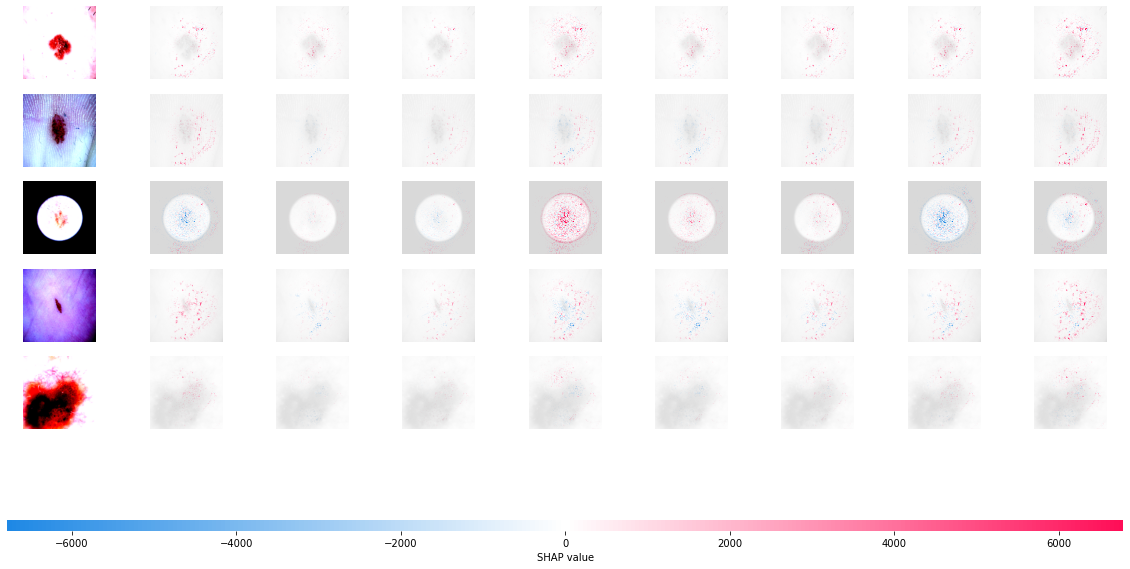

In [12]:
# plot the feature attributions
tst = test_images.numpy()
shap.image_plot(shap_numpy, test_numpy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


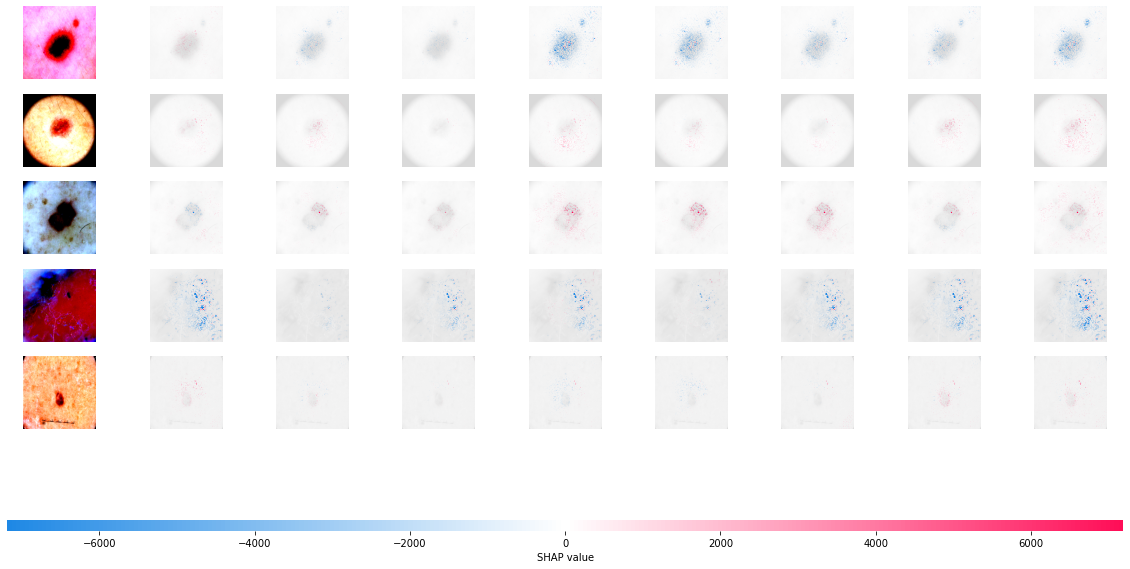

In [52]:
# plot the feature attributions
tst = test_images.numpy()
shap.image_plot(shap_numpy, test_numpy)

More is possible - https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html

<h2>Explaining an Intermediate Layers of VGG16 </h2>


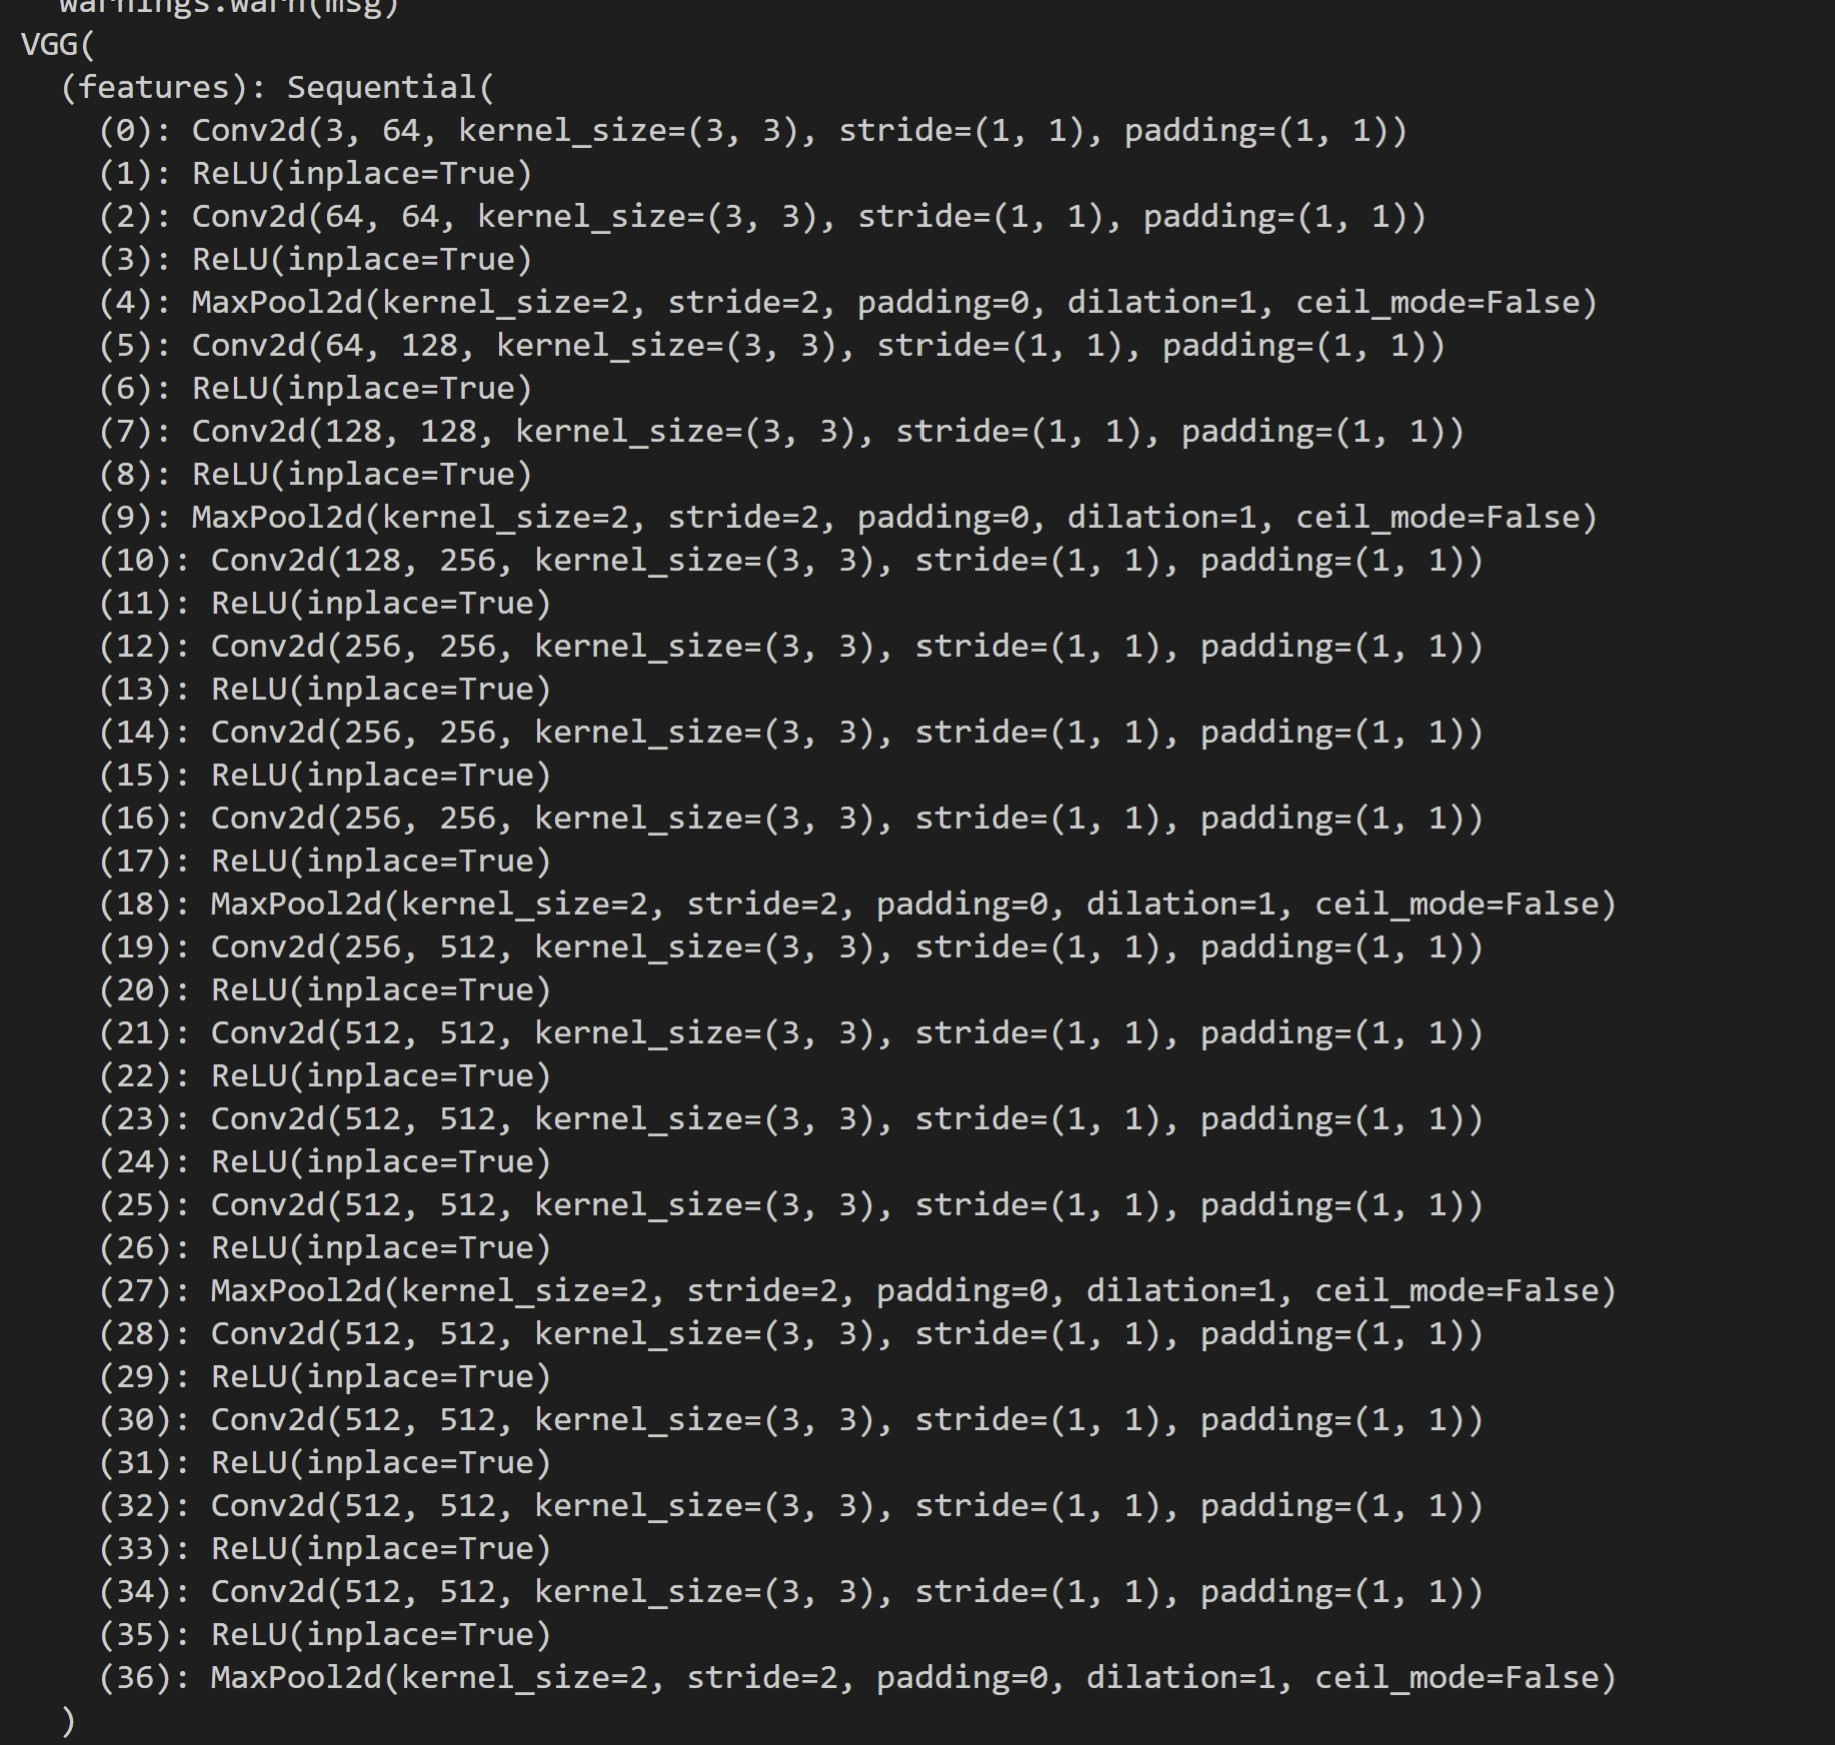

In [ ]:
e = shap.GradientExplainer((model, model.backbone.features[7]), input)
shap_values,indexes = e.shap_values(test_images, ranked_outputs=2, nsamples=200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


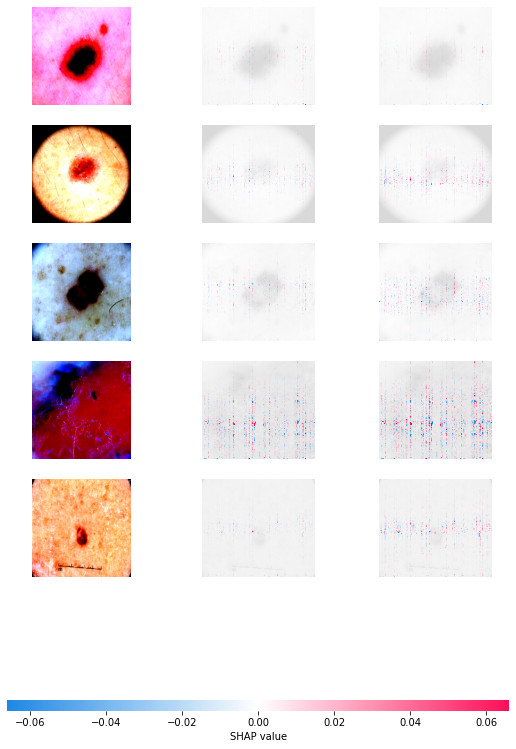

In [57]:
# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, test_numpy)

In [59]:
e2 = shap.GradientExplainer((model, model.backbone.features[30]), input)
shap_values2,indexes = e2.shap_values(test_images, ranked_outputs=2, nsamples=200)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


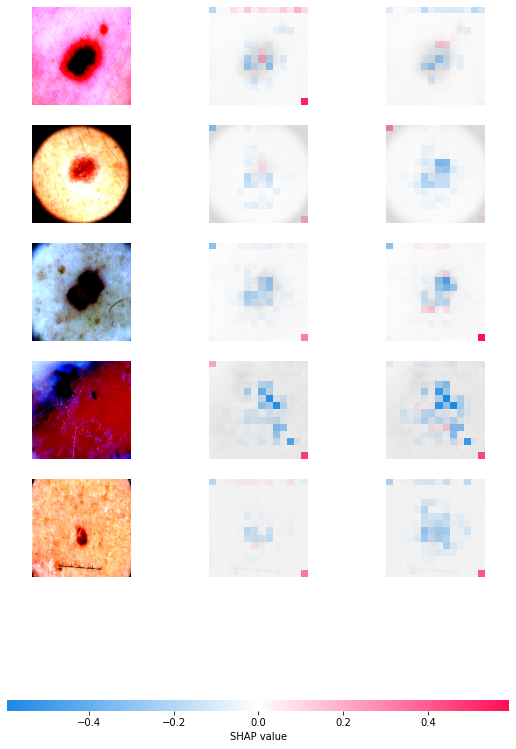

In [60]:
# plot the explanations
shap_values2 = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values2]

shap.image_plot(shap_values2, test_numpy)

In [66]:
e3 = shap.GradientExplainer((model, model.backbone.features[30]), input,local_smoothing=0.5)
shap_values3,indexes = e3.shap_values(test_images, ranked_outputs=2, nsamples=50)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


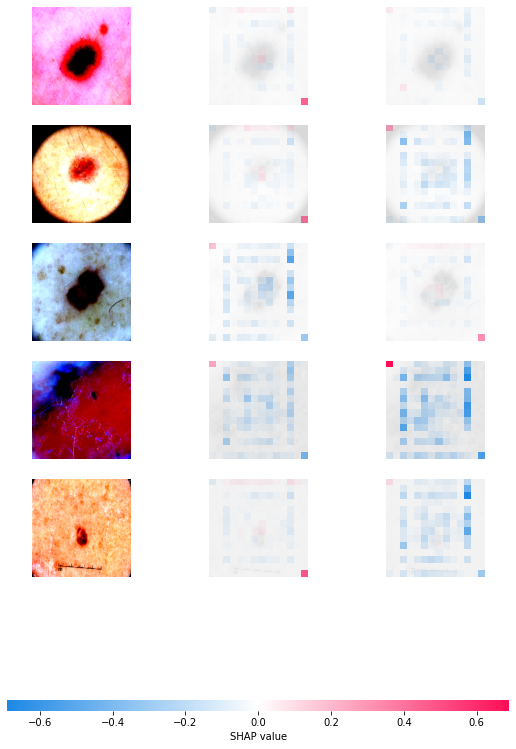

In [67]:
# plot the explanations
shap_values3 = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values3]
shap.image_plot(shap_values3, test_numpy)

In [13]:
e4 = shap.GradientExplainer((model, model.backbone.features[15]), input,local_smoothing=0.5)
shap_values4,indexes = e4.shap_values(test_images, ranked_outputs=2, nsamples=150)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


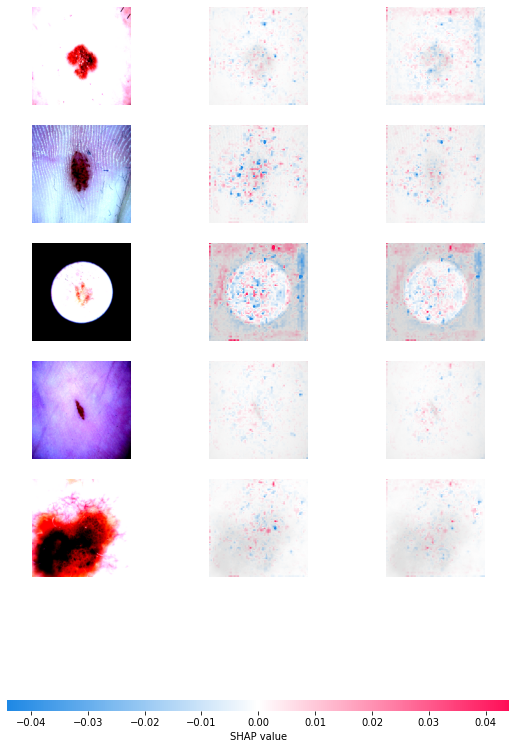

In [15]:
# plot the explanations
shap_values4 = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values4]
shap.image_plot(shap_values4, test_numpy)